In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm


from sklearn.metrics import fbeta_score, accuracy_score, balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix, f1_score

from joblib import load
from sklearn.inspection import partial_dependence, PartialDependenceDisplay


### Constantes:
seed=123


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [24]:
logistic_model = load('../modelos/regresionlog.joblib')

df_test = pd.read_csv('../data/df_test_scaled.csv')
y_test = df_test['TARGET']
x_test = df_test.drop('TARGET', axis=1)

logistic_model

LogisticRegression(C=0.89, l1_ratio=0.23, penalty='l1', random_state=123,
                   solver='saga')

# Resultados

In [38]:
## Saco las predicciones de mi modelo para el conjunto de test
y_pred = logistic_model.predict(x_test)

## Sacamos las predicciones probabilísticas de cada instancia 
y_proba = logistic_model.predict_proba(x_test)

In [35]:
## Métricas básicas
f2score = fbeta_score(y_test, y_pred, beta=2)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(accuracy)
print(f2score)
print(recall)

0.8121555046095312
0.36019417475728155
0.44833836858006043


Confusion matrix, without normalization
[[47724  8814]
 [ 2739  2226]]
Normalized confusion matrix
[[0.84410485 0.15589515]
 [0.55166163 0.44833837]]


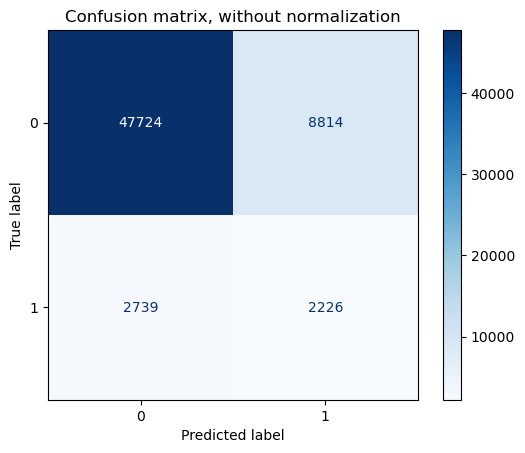

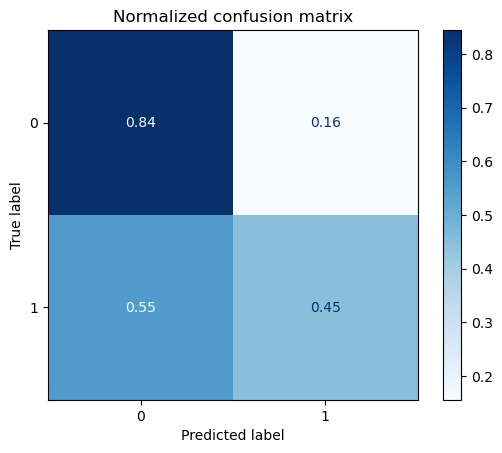

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(logistic_model, x_test, y_test,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Curva Roc

La curva ROC (Receiver Operating Characteristic) sirve para evaluar el desempeño de un modelo de clasificación binaria al mostrar la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos a medida que se varía el umbral de decisión. Su propósito fundamental es analizar cómo de bien un modelo puede discriminar entre las dos clases (positiva y negativa) y ayudar a seleccionar el umbral de decisión más adecuado dependiendo de los objetivos del problema.

La curva ROC es especialmente útil en problemas donde existe un compromiso entre los errores que un modelo puede cometer: incrementar los aciertos en una clase (verdaderos positivos) suele implicar aceptar más errores en la otra clase (falsos positivos). Esta herramienta permite visualizar ese **trade-off** para tomar decisiones informadas.

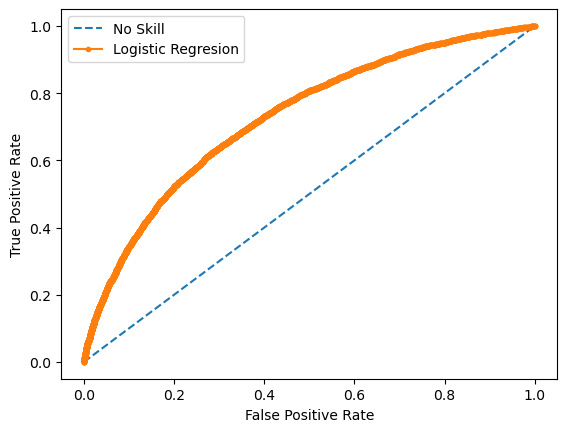

In [ ]:
y_hat = y_proba[:,1]


## Creamos una curva roc para la predicción de '1'

fpr, tpr, thresholds = roc_curve(y_test, y_hat)

plt.plot([0,1], [0,1], linestyle= '--', label = 'No Skill')  ## linea aleatoriedad
plt.plot(fpr, tpr, marker='.', label='Logistic Regresion')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [ ]:
# calcula la media geométrica para cada combinación de puntos 
gmeans = np.sqrt(tpr * (1-fpr))
# calcula el punto en el que se maximiza la media geométrica
ix= np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.379468, G-Mean=0.669


Best Threshold=0.379468, G-Mean=0.669


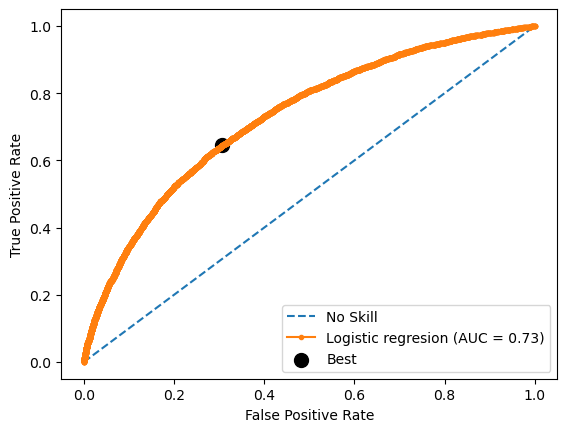

In [ ]:
# calculate AUC
roc_auc = roc_auc_score(y_test, y_hat)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')    ## Caso de aleatoriedad
plt.plot(fpr, tpr, marker='.', label=f'Logistic regresion (AUC = {roc_auc:.2f})') 

plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Gain Curve y Lift Curve

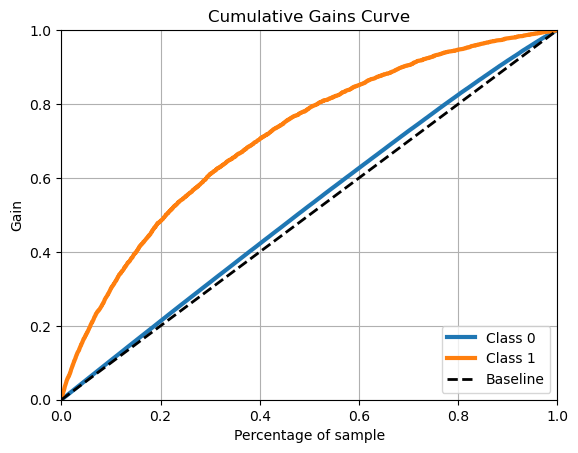

In [53]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(y_test, y_proba)
plt.show()

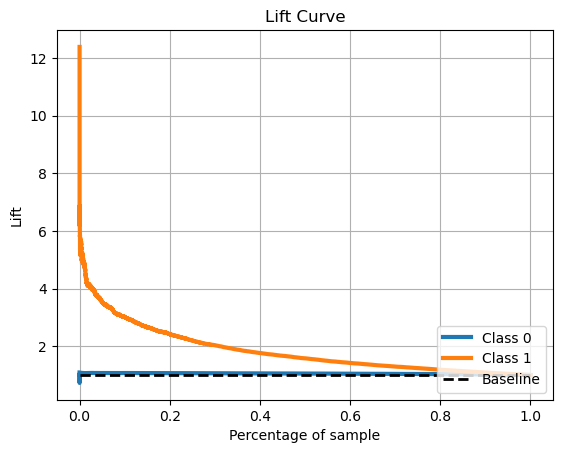

In [54]:
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.show()

# Partial Dependence Plots (PDP)

Los Partial Dependence Plots (PDP) son gráficos que muestran cómo cambia la predicción promedio de un modelo de machine learning cuando una o más características de entrada se varían, manteniendo constantes las demás características. Su propósito es entender cómo una característica afecta el comportamiento general del modelo.



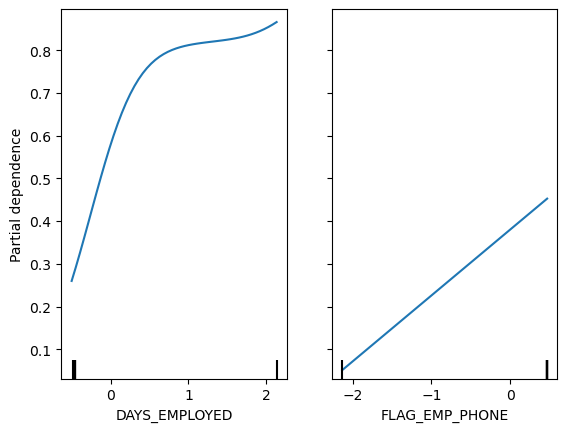

In [ ]:
# PDP para una característica
PartialDependenceDisplay.from_estimator(
    logistic_model,
    x_test,
    ['DAYS_EMPLOYED', 'FLAG_EMP_PHONE'],  # Varias características
    grid_resolution=50
)

plt.show()

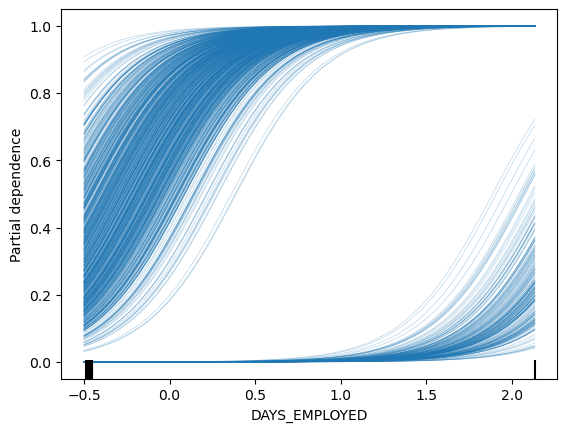

In [102]:
PartialDependenceDisplay.from_estimator(
    logistic_model,
    x_test,
    ['DAYS_EMPLOYED'],
    kind='individual',  # Cambiar a ICE
    grid_resolution=50
)

plt.show()


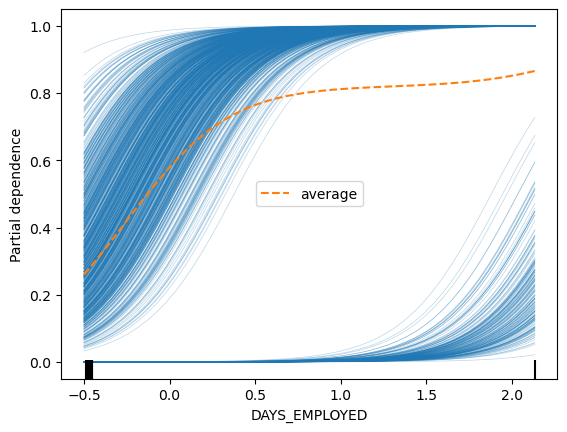

In [103]:
from sklearn.inspection import PartialDependenceDisplay

# Graficar PDP + ICE para una característica
PartialDependenceDisplay.from_estimator(
    logistic_model,
    x_test,
    ['DAYS_EMPLOYED'],  # Característica a analizar
    kind='both',  # Muestra tanto PDP como ICE
    grid_resolution=50  # Resolución del gráfico
)

plt.show()


# 4. - Explicabilidad - SHAP

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.

 The sum of all SHAP values will be equal to E[f(x)] — f(x).

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [55]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
### Definimos como va a ser el explicador 
## explainer = shap.LinearExplainer(logistic_model.best_estimator_.named_steps['classifier'], x_test)

## Como lo he entrenado con los parámetros óptimos directamente, no tengo que buscar el mejor
explainer = shap.LinearExplainer(logistic_model, x_test)
print(explainer)
## creamos el explicador, aquí el dataset que le damos es para definir el explicador, en la siguiente celda
## es el dataset del que va a calcular los shap values
    ## podríamos calcular los valores shap de distintos datasets con el mismo explicador


In [78]:
## Calcula los valores shap de nuestro explicador par los variables independientes de validación
## The explainer variable will have three attributes: .values, .base_values and .data
##  - .dataattribute is simply a copy of the input data
##  - .base_values is the expected value of the target, or the average target value of all the train data
##  - .values are the SHAP values for each example
shap_values = explainer.shap_values(x_test)
print(shap_values)

[[-0.08474723 -0.11588419 -0.13474124 ...  0.09274082 -0.08775413
  -0.17927971]
 [ 1.78221241  0.08787967 -1.84682822 ... -0.11566552  0.11056029
   0.06630894]
 [-0.7696187  -0.04517733  0.72130224 ...  0.09274082 -0.08775413
   0.06630894]
 ...
 [ 2.31159067  0.72038831 -2.7028717  ...  0.09274082 -0.08775413
   0.06630894]
 [-1.36408714 -0.18158703  1.57734573 ...  0.09274082 -0.08775413
   0.06630894]
 [-0.8207923  -0.17563224  1.35477442 ... -0.11566552  0.06098168
   0.06630894]]


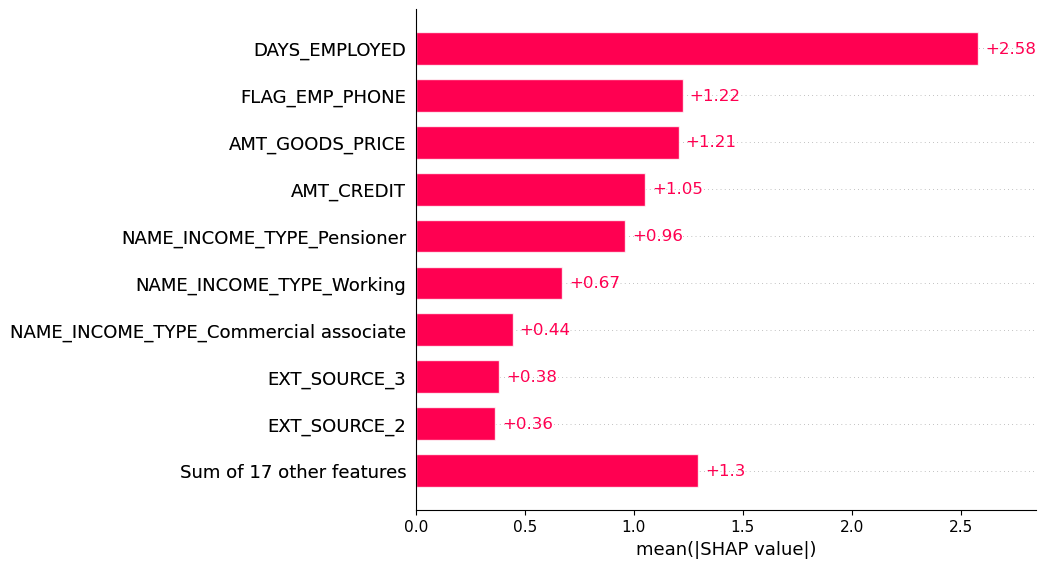

In [89]:
# shap.Explanation es una estructura de datos de SHAP que organiza la información necesaria para interpretar y visualizar los valores SHAP de un modelo.
# Combina los valores SHAP con datos adicionales como valores base, características originales
# y nombres de las mismas, proporcionando un formato estándar para la visualización y el análisis.

# Crear un objeto Explanation
shap_exp = shap.Explanation(
    values=shap_values,     ## valores SHAP
    base_values=explainer.expected_value,   ## Valore medio esperado antes de recibir ninguna caract.
    data=x_test,
    feature_names=x_test.columns
)

# Generar el gráfico de barras
shap.plots.bar(shap_exp)

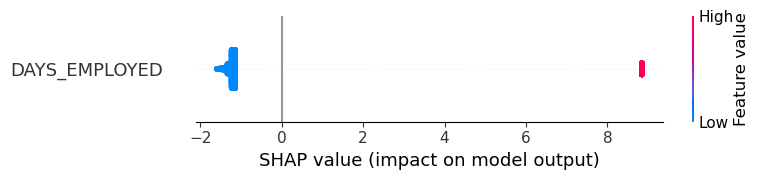

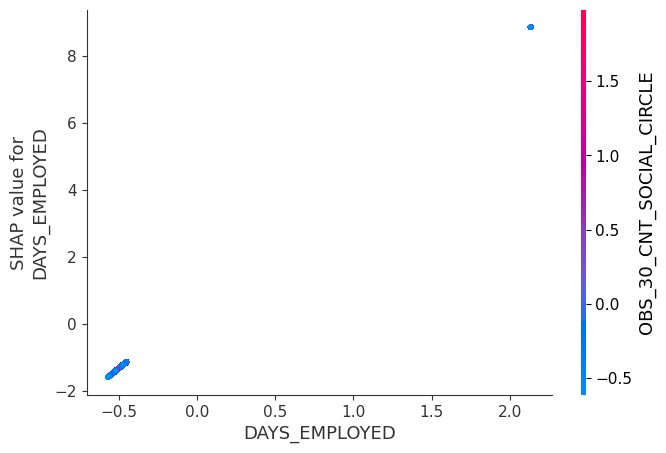

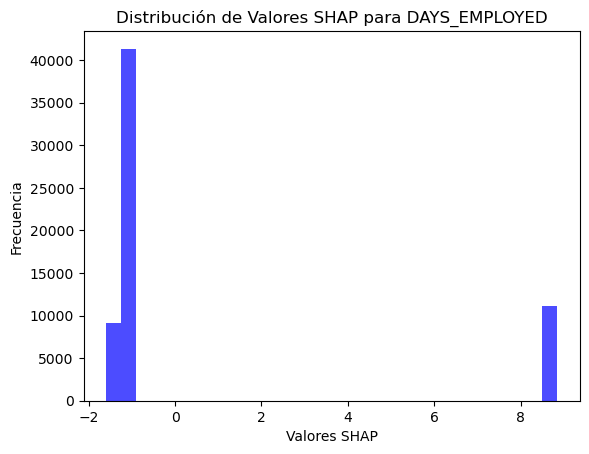

In [63]:
# Seleccionar una instancia (por ejemplo, la primera fila)
## instance_idx = 'DAYS_EMPLOYED'  # Cambia este índice para analizar otras instancias
## shap_instance = shap_values[instance_idx]

# Seleccionar la característica deseada
feature_name = 'DAYS_EMPLOYED'

# Obtener el índice de la característica en el dataset
feature_idx = x_test.columns.get_loc(feature_name)

# Extraer todos los valores SHAP correspondientes a la característica
feature_shap_values = shap_values[:, feature_idx]

# Crear un gráfico resumen (beeswarm) solo para la característica seleccionada
shap.summary_plot(
    shap_values=np.expand_dims(feature_shap_values, axis=1), 
    features=x_test[[feature_name]],
    feature_names=[feature_name]
)

# Gráfico de dependencia para 'DAYS_EMPLOYED'
shap.dependence_plot(
    feature_name,          # Nombre de la característica
    shap_values,           # Todos los valores SHAP (puede incluir varias características)
    x_test                  # Dataset original
)

import matplotlib.pyplot as plt

plt.hist(shap_values[:, feature_idx], bins=30, color='blue', alpha=0.7)
plt.title(f'Distribución de Valores SHAP para {feature_name}')
plt.xlabel('Valores SHAP')
plt.ylabel('Frecuencia')
plt.show()

In [91]:
x_test.columns.get_loc('DAYS_EMPLOYED')
print(type(shap_values))

<class 'numpy.ndarray'>


In [93]:
# Convertir shap_values a un objeto shap.Explanation
shap_exp = shap.Explanation(
    values=shap_values,                      # Valores SHAP (array de NumPy)
    base_values=explainer.expected_value,    # Valor base del modelo
    data=x_test,                             # Datos originales de entrada
    feature_names=x_test.columns             # Nombres de las características
)

print(type(shap_exp))

<class 'shap._explanation.Explanation'>


In [ ]:
# Asegurarse de convertir a un array NumPy
shap.plots.scatter(
    shap_exp[:, 'DAYS_EMPLOYED'].values,  # Convertir a array NumPy
    color=shap_exp[:, 'FLAG_EMP_PHONE'].values  # Convertir también a array NumPy
)

.values =
array([[-0.08474723, -0.11588419, -0.13474124, ...,  0.09274082,
        -0.08775413, -0.17927971],
       [ 1.78221241,  0.08787967, -1.84682822, ..., -0.11566552,
         0.11056029,  0.06630894],
       [-0.7696187 , -0.04517733,  0.72130224, ...,  0.09274082,
        -0.08775413,  0.06630894],
       ...,
       [ 2.31159067,  0.72038831, -2.7028717 , ...,  0.09274082,
        -0.08775413,  0.06630894],
       [-1.36408714, -0.18158703,  1.57734573, ...,  0.09274082,
        -0.08775413,  0.06630894],
       [-0.8207923 , -0.17563224,  1.35477442, ..., -0.11566552,
         0.06098168,  0.06630894]])

.base_values =
-0.851660636531972

.data =
       AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_INCOME_TYPE_Working  \
0        0.190390    -0.526741         0.372308                 -1.033175   
1        1.717855     0.741317         1.594287                 -1.033175   
2       -0.369942    -0.086720        -0.238682                  0.967890   
3        1.197946     1.7

In [64]:
x_test.iloc[0,:]

AMT_CREDIT                               1.903901e-01
AMT_ANNUITY                             -5.267408e-01
AMT_GOODS_PRICE                          3.723080e-01
NAME_INCOME_TYPE_Working                -1.033175e+00
NAME_INCOME_TYPE_State servant          -2.748005e-01
NAME_INCOME_TYPE_Pensioner               2.133976e+00
NAME_INCOME_TYPE_Commercial associate   -5.515152e-01
DAYS_EMPLOYED                            2.133384e+00
FLAG_EMP_PHONE                          -2.133389e+00
REGION_RATING_CLIENT_W_CITY             -6.319187e-02
ORGANIZATION_TYPE                       -1.342503e+00
EXT_SOURCE_1                             1.618231e+00
EXT_SOURCE_2                             6.809269e-01
EXT_SOURCE_3                             2.221895e-01
APARTMENTS_AVG                          -3.644865e-01
BASEMENTAREA_AVG                        -5.225548e-16
ENTRANCES_AVG                           -1.147701e+00
NONLIVINGAREA_AVG                        4.214783e-01
BASEMENTAREA_MODE           

In [65]:
shap.force_plot(explainer.expected_value, shap_values[0], x_test.iloc[0,:])

**En una regresión logística binaria, expected_value es un escalar y no un vector. Esto sucede porque el modelo solo tiene una salida, correspondiente a la probabilidad de la clase positiva**. Por tanto no necesio específicar el que número de valor esperado cojo, si fuera
un árbol de decisión el modelo puede manejar múltiples salidas o clases en una clasificación multiclase. Por esta razón, expected_value es un vector que contiene un valor base para cada clase. Cada valor base representa la predicción promedio de esa clase antes de que las características específicas ajusten el resultado. Tendriamos:
- expected_value[0] para la primera clase.
- expected_value[n] así para cadda posible clase.

En modelos con múltiples salidas (por ejemplo, clasificación multiclase), expected_value sería un vector que contiene un valor base para cada clase. En esos casos, necesitaría especificar el índice para seleccionar el valor base correspondiente a una clase específica (por ejemplo, [0] para la clase positiva en binaria o la primera clase en multiclase).

In [66]:
## shap_values[:100,:] --> de las primera 100 instancias -- Extrae los valores shap
## X_val.iloc[:100, :] --> solo pasamos la 100 primeras filas del df

shap.force_plot(explainer.expected_value, shap_values[:200,:], features=x_test.iloc[:200, :])

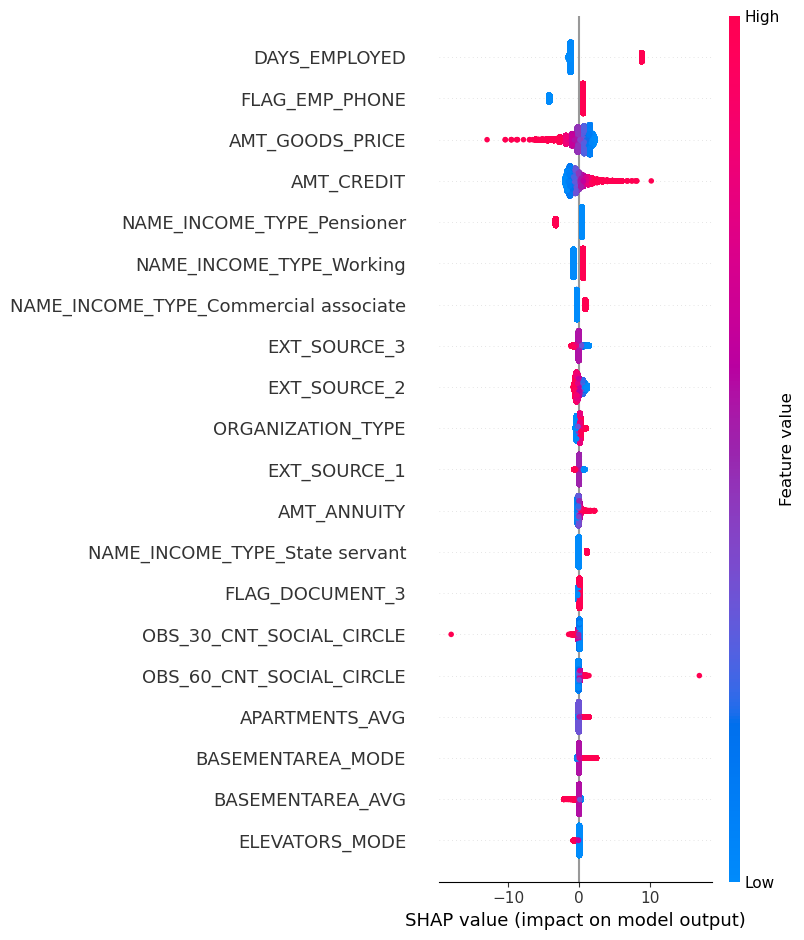

In [106]:
plt.rcParams.update({'ytick.labelsize': 8})  # Cambia el tamaño de las etiquetas en el eje Y
shap.summary_plot(shap_values, features=x_test)
# Si necesitas restaurar el tamaño original de la fuente para gráficos futuros:
plt.rcdefaults()


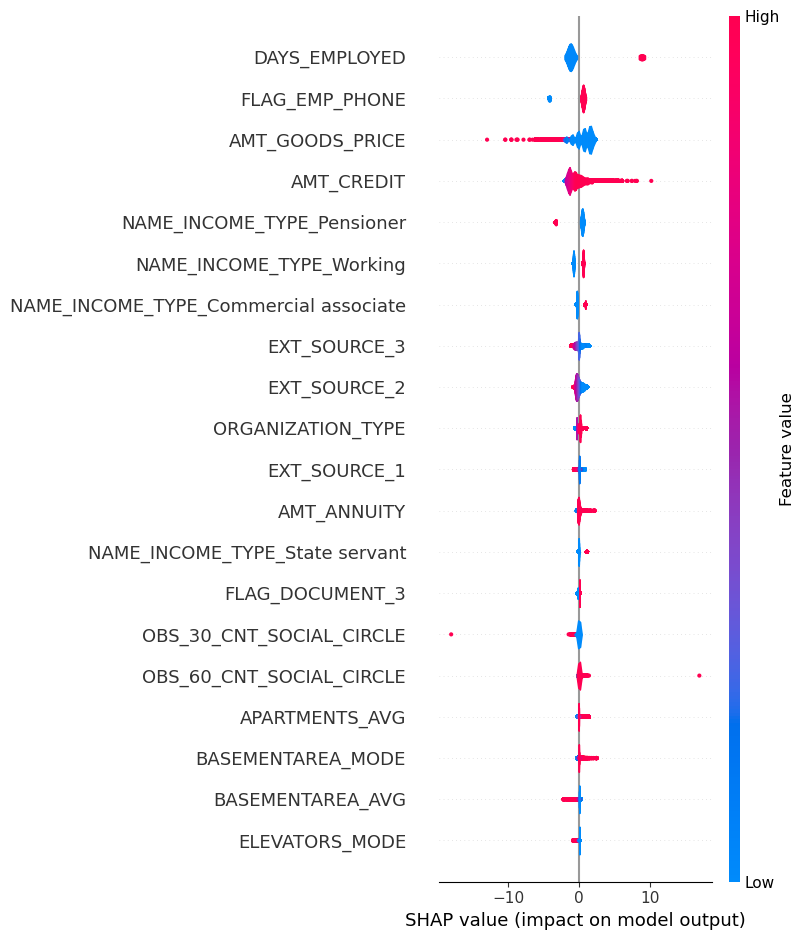

In [68]:
shap.summary_plot(shap_values, features= x_test, plot_type='violin')